# 机器学习 实验五

**题目：层次聚类**  
实验条件：给定三维数据集 data.dat 及其类别 label.dat  
实验要求：  
1. 基本要求：绘制聚类前后样本分布情况。
   - 实现 single-linkage 层次聚类算法；
   - 实现 complete-linkage 层次聚类算法。
2. 中级要求：实现 average-linkage 层次聚类算法，绘制样本分布图。
3. 提高要求：对比上述三种算法，给出结论。 
4. 拓展要求：通过变换聚类簇的个数，测试上述三种算法的性能，并给出分析。

# 导入需要的包

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [132]:
# 提取数据
f1 = open('data.dat', 'r')
f2 = open('label.dat', 'r')
sample_num = 2000
data = []
label = []
for i in range(sample_num):
    data.append(f1.readline().split())
    label.append(f2.readline())
    label[i] = int(label[i][0]) + 1
    for j in range(3):
        data[i][j] = float(data[i][j][:-4])

data = np.array(data)

In [133]:
def plot(data, label):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    #ax = fig.add_subplot(1,1,1)
    colors = 'rgbyckm'
    for i in range(sample_num):
        ax.scatter(data[i][0],data[i][1],data[i][2],color=colors[label[i]-1],s=np.pi)
    plt.show()

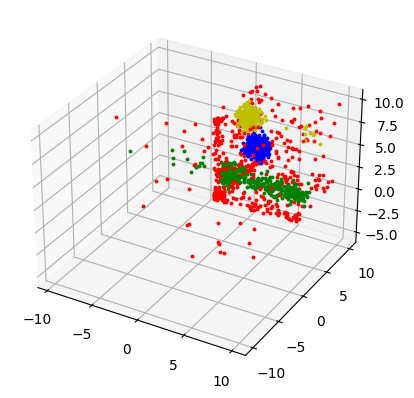

In [134]:
plot(data,label)

# 基本/中级要求

In [58]:
# 类间距离是两个类样本之间的最短距离
def single_linkage(X):
    return np.min(X, axis=0)

# 类间距离是两个类样本之间的最长距离
def complete_linkage(X):
    return np.max(X, axis=0)

In [49]:
# 类间距离是两个类样本之间的平均距离
def average_linkage(X):
    return np.average(X, axis=0)

In [136]:
class Hierarchical_clustering:
    def __init__(self):
        # 记录每次合并
        self.steps = []
    
    def fit(self, data, method):
        self.sample_num = data.shape[0]
        dotdist = np.zeros((self.sample_num,self.sample_num))
        # 计算点间距离
        for i in range(self.sample_num):
            for j in range(i):
                dotdist[i][j] = dotdist[j][i] = np.sum((data[i]-data[j])**2)
        clusterlist = [[i] for i in range(self.sample_num)]
        clustercnt = self.sample_num
        #print(clusterlist)
        print("calculate distance finished.")
        # 初始化聚类间距离矩阵
        clusterdist = np.zeros((clustercnt, clustercnt)) + 1e3
        for i in range(clustercnt):
            for j in range(i+1, clustercnt):
                clusterdist[i][j] = clusterdist[j][i] = dotdist[i][j]
        #print(clusterdist)
        print("calculate cluster distance finished.")
        
        while clustercnt!=1:
            # 最相似的两个聚类
            res = np.argmin(clusterdist) # 最小距离对应展开的下标
            dest, src = int(res/clustercnt), res % clustercnt # 获得下标对应的行和列
            # 在steps里记录合并的两个聚类的索引
            #print("most similar groups:",dest, src)
            self.steps.append((clusterlist[dest][0], clusterlist[src][0]))
            modify = method(clusterdist[[dest, src]]) # 计算新的类间距离
            #print("distance:",modify)
            # 聚类间距离矩阵更新
            clusterdist[dest] = modify
            clusterdist[:,dest] = modify
            #print(clusterdist)
            clusterdist = np.delete(clusterdist, src, axis=0)
            clusterdist = np.delete(clusterdist, src, axis=1)
            clusterdist[dest][dest] = 1e3
            #print(clusterdist)
            # 聚类更新
            clusterlist[dest] += clusterlist[src]
            del clusterlist[src]
            #print(clusterlist)
            clustercnt -= 1
            if(self.sample_num - clustercnt) % (self.sample_num/4) == 0:
                print(clustercnt," clusters left.")
        print("cluster finished.")
    
    def label(self, k): # 最终生成k个类
        root = list(range(self.sample_num))
        #print("initial root: ",root)
        def find_root(n): # 一个类的root
            if root[root[n]] == root[n]:
                return root[n]
            root[n]=find_root(root[n])
            return root[n]
        for i in range(self.sample_num-k): 
            dest, src = self.steps[i] # 找到合并的两个类
            #print("dest, src: ",dest,src)
            root[find_root(src)] = find_root(dest) # 将其中一个的root挂在另一个的root下面
            #print("root update:",root)
        cluster, clustercnt = [0 for i in range(self.sample_num)], 0
        for i in range(self.sample_num): # 将root标注为聚类
            if i == root[i]:
                clustercnt += 1
                cluster[i] = clustercnt
        #print(cluster,"clustercnt=",clustercnt)
        for i in range(self.sample_num): # 将非root的类标注为root
            if i != root[i]: 
                cluster[i] = cluster[find_root(i)]
        #print(cluster)
        return cluster

single_linkage
calculate distance finished.
calculate cluster distance finished.
1500  clusters left.
1000  clusters left.
500  clusters left.
cluster finished.


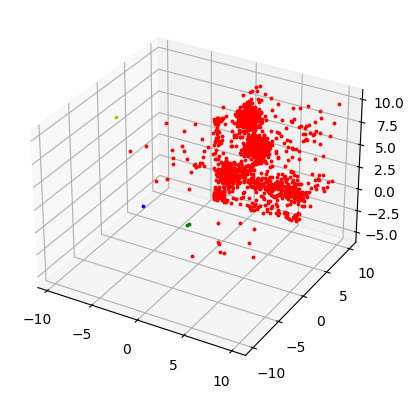

complete_linkage
calculate distance finished.
calculate cluster distance finished.
1500  clusters left.
1000  clusters left.
500  clusters left.
cluster finished.


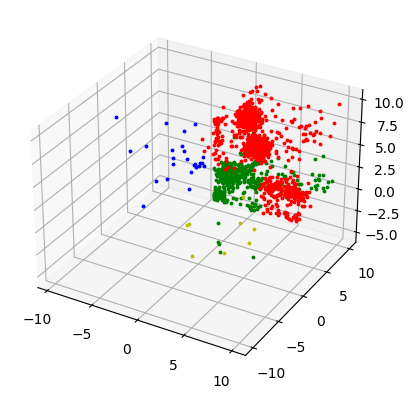

average_linkage
calculate distance finished.
calculate cluster distance finished.
1500  clusters left.
1000  clusters left.
500  clusters left.
cluster finished.


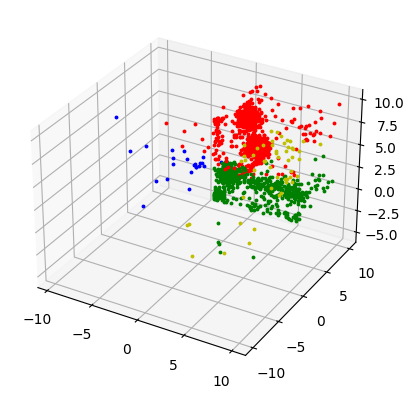

In [138]:
methods = [single_linkage, complete_linkage, average_linkage]
k = 4
pred_label = []
for i, method in enumerate(methods):
    model = Hierarchical_clustering()
    print(method.__name__)
    model.fit(data, method)
    pred_label.append(model.label(k))
    plot(data, model.label(k))

# 提高要求

上述分别是 k = 4 时的 single-linkage, complete-linkage, average-linkage 的分类结果。  
- 由于数据存在很多孤立点，导致那些原本距离并不近的 cluster 相较之下最短距离也比较小，single-linkage 的分类结果明显比较差，最后得到的是一个非常大、囊括了绝大多数数据点的 cluster 和一些只包括了很远的孤立点的小 cluster；
- complete-linkage 会导致即使两个 cluster 已经很近，但只要存在不符合数据整体分布的离群点，就无法合并；
- average-linkage 比起上述二者，能比较好地考虑到数据整体分布情况，分类效果是最好的。

另外，由于本次实验的数据集并不是非常理想（从最初根据给定标签画出的图可以看出，红色点所在的 cluster 基本就是较为聚集的另三个 cluster 剩下的离散点），而三种算法都没有很好地构建出这个 cluster，而是把它拆散了，另外都将原本的蓝色和黄色两个 cluster 合并在一起，这充分体现了层次聚类的 winner-takes-all 特点，即原本体量就大的 cluster 倾向于变得更大，分类结果很不均匀。